In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import sys

import astropy
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy import units as u

from collections import namedtuple


import glob


In [2]:
import keras
from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [3]:
# my home-written modules
import image_helpers
import split_sets
import model_helpers

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
plt.rcParams['savefig.dpi'] = 80*2
plt.rcParams['figure.dpi'] = 80*2
plt.rcParams['figure.figsize'] = np.array((10,6))*.5
plt.rcParams['figure.facecolor'] = "white"

In [6]:
data_dir = image_helpers.data_dir


# Load data

In [7]:
df = pd.read_csv(os.path.join(data_dir, "matched_galaxies.csv"))
df = df.set_index("SpecObjID")
print(df.shape)
df.head()

(129702, 88)


,BESTOBJID,FIBERID,HTMID,PLATEID,SPECOBJID,SPECTROGRAPHID,TARGETID,TARGETOBJID,OBJTYPENAME,SCIENCEPRIMARY,...,primTarget,secTarget,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,htmID,fieldID,size
SpecObjID,,,,,,,,,,,,,,,,,,,,,
75094093037830144,0,17,10570139305399,75094092966526976,75094093037830144,1,284705867169812,0,GALAXY,1,...,64,0,0.379354,0.279125,0.202445,0.153508,0.108839,10570139305399,587725073921540096,4.297720
75094093138493440,0,41,10570179932652,75094092966526976,75094093138493440,1,284722522292399,0,GALAXY,1,...,64,0,0.273461,0.201210,0.145934,0.110658,0.078458,10570179932652,588848898824273920,8.377118
75094093180436480,0,51,10570166742677,75094092966526976,75094093180436480,1,284722522292321,0,GALAXY,1,...,64,0,0.320851,0.236079,0.171224,0.129834,0.092054,10570166742677,588848898824273920,4.254059
75094093243351040,0,66,10552759033190,75094092966526976,75094093243351040,1,284723059294422,0,GALAXY,1,...,64,0,0.707734,0.520744,0.377687,0.286388,0.203053,10552759030425,588848899361275904,3.969658
75094093398540288,0,103,10552790951266,75094092966526976,75094093398540288,1,284723596034444,0,GALAXY,1,...,64,0,0.821007,0.604089,0.438136,0.332225,0.235552,10552790951266,588848899898015744,12.901030


In [8]:
# targets
df_Y = df[["MEDIAN"]]
df_Y.head()


,MEDIAN
SpecObjID,
75094093037830144,9.052521
75094093138493440,9.136789
75094093180436480,9.050070
75094093243351040,9.131351
75094093398540288,8.706560


MEDIAN    0.040022
dtype: float64


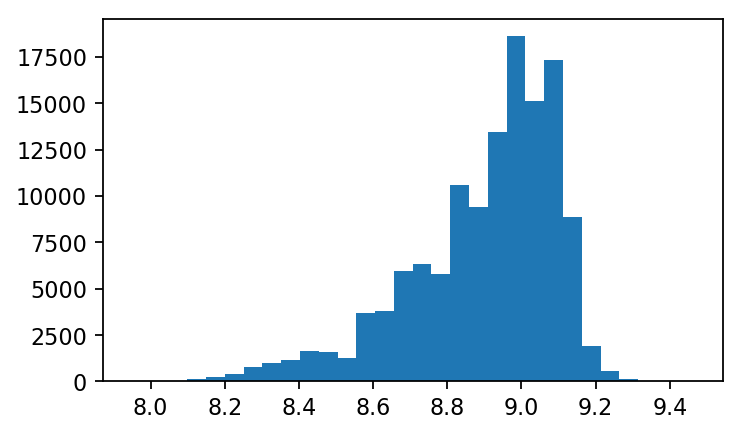

In [9]:
plt.hist(df_Y.MEDIAN.values, bins=30)
print(df_Y.var())

In [10]:
ids_with_images = glob.glob(os.path.join(data_dir, 
                                         "images",
                                         "processed",
                                         "*.npy"))
ids_with_images = [os.path.split(filename)[1].replace(".npy", "")
                   for filename in ids_with_images]
ids_with_images = np.array(ids_with_images, dtype=int)

ids_with_images_full = ids_with_images.copy()
# ids_with_images = ids_with_images[:10000]

# Split training and validation

In [11]:
id_sets = split_sets.split_indices(ids_with_images, 
                                   num_testing=0, # keep 0 while testing out the code
                                  )
training_ids, validation_ids, _ = id_sets

df_Y["target"] = df_Y["MEDIAN"] - df_Y.loc[training_ids].MEDIAN.mean()

/Users/egentry/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
image_filename_format = os.path.join(data_dir, 
                                     "images", 
                                     "processed", 
                                     "{}.npy")

In [13]:
class ReadFromDiskSequence(keras.utils.Sequence):

    def __init__(self, training_ids, 
                 df_Y=df_Y,
                 batch_size=128,
                 max_num_batches=2**31,
                 num_channels=5,
                 image_shape=(95,95),
                 image_filename_format=image_filename_format,
                 horizontal_flip=True,
                 verticle_flip=True,
                 shuffle_each_epoch=True,
                ):
        self.training_ids = training_ids
        self.df_Y = df_Y
        self.batch_size = batch_size
        self.num_batches = min(
            int(np.ceil(len(training_ids) / batch_size)),
            max_num_batches,
               )
        self.batch_images_shape = (batch_size, 
                                   num_channels, 
                                   *image_shape)
        
        self.filename_format = image_filename_format
        
        self.shuffle_each_epoch = shuffle_each_epoch
        
        # data augmentation options
        self.horizontal_flip = horizontal_flip
        self.verticle_flip = verticle_flip
        
        self.on_epoch_end()
        

    def __len__(self):
        return self.num_batches
    
    def on_epoch_end(self):
        if self.shuffle_each_epoch:
            self.shuffled_ids = np.random.permutation(training_ids)
        else:
            self.shuffled_ids = training_ids


    def __getitem__(self, idx):
        batch_ids = self.shuffled_ids[idx*self.batch_size:
                                      (idx+1)*self.batch_size]

        X = np.empty(self.batch_images_shape)
        for i, galaxy_id in enumerate(batch_ids):
            img = np.load(self.filename_format.format(galaxy_id))
            if self.verticle_flip:
                if np.random.choice((True, False)):
                    img = img[:,:,::-1]
            if self.horizontal_flip:
                if np.random.choice((True, False)):
                    img = img[:,::-1,:]
            X[i] = img
        Y = df_Y.loc[batch_ids].target.values.flatten()

        return X, Y


In [14]:
data_generator_training = ReadFromDiskSequence(training_ids,
                                               max_num_batches=50)
data_generator_validation  = ReadFromDiskSequence(validation_ids,
                                                  max_num_batches=50)

res = data_generator_training.__getitem__(1)

In [15]:
res[0].shape

(128, 5, 95, 95)

In [16]:
res[1].shape

(128,)

In [17]:
K.set_session(
    K.tf.Session(
        config=K.tf.ConfigProto(intra_op_parallelism_threads=4, 
                                inter_op_parallelism_threads=4)
    )
)

model = model_helpers.build_model((5,95,95),
                                  with_one_by_one=False,
                                 )

logger_filename = "./test.vanilla.log"
model = model_helpers.compile_model(model, logger_filename)

In [18]:
earlystopping = keras.callbacks.EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


In [19]:
csv_logger = keras.callbacks.CSVLogger(logger_filename,
                                       append=True)

In [21]:
# modelcheckpoint = keras.callbacks.ModelCheckpoint(pathinCat+'Models/bestmodelMAG.hdf5',monitor='val_loss',verbose=0,save_best_only=True)


# Run Model

In [29]:
batch_size = data_generator_training.batch_size
steps_per_epoch = data_generator_training.num_batches
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 100
verbose = 1

steps_per_epoch:  50
batch_size:  128


In [30]:
history = model.fit_generator(
    data_generator_training,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=data_generator_validation,
    verbose=verbose,
    callbacks=[
#         earlystopping,
        csv_logger,
    ],
)  

Epoch 1/100
50/50 [==============================] - 2525s 50s/step - loss: 0.0262 - val_loss: 0.0253
Epoch 2/100
50/50 [==============================] - 2489s 50s/step - loss: 0.0268 - val_loss: 0.0270
Epoch 3/100
50/50 [==============================] - 2498s 50s/step - loss: 0.0259 - val_loss: 0.0255
Epoch 4/100
50/50 [==============================] - 2536s 51s/step - loss: 0.0249 - val_loss: 0.0256
Epoch 5/100
50/50 [==============================] - 2539s 51s/step - loss: 0.0266 - val_loss: 0.0269
Epoch 6/100
50/50 [==============================] - 2483s 50s/step - loss: 0.0268 - val_loss: 0.0276
Epoch 7/100
50/50 [==============================] - 2490s 50s/step - loss: 0.0264 - val_loss: 0.0251
Epoch 8/100
50/50 [==============================] - 2468s 49s/step - loss: 0.0249 - val_loss: 0.0268
Epoch 9/100
50/50 [==============================] - 2484s 50s/step - loss: 0.0252 - val_loss: 0.0259
Epoch 10/100
50/50 [==============================] - 2486s 50s/step - loss: 0.025

KeyboardInterrupt: 

In [31]:
df = pd.read_csv(logger_filename)
# df = pd.read_csv("test.log")



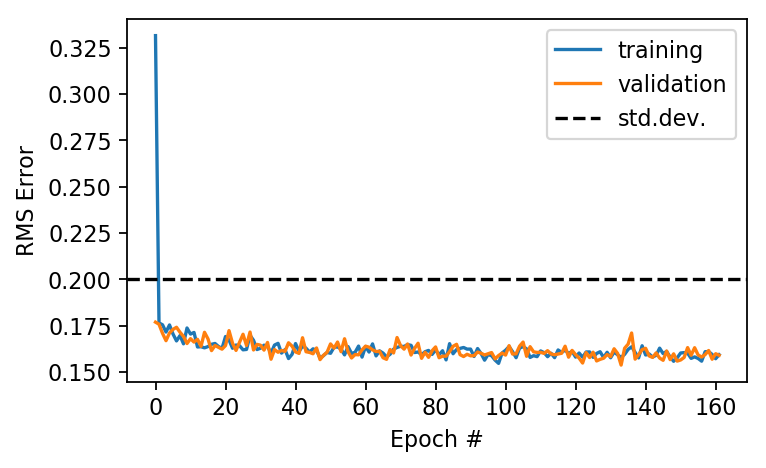

In [32]:
plt.plot(df.loss**.5, label="training")
plt.plot(df.val_loss**.5, label="validation")

plt.axhline(df_Y.MEDIAN.std(), 
            linestyle="dashed", color="black",
            label="std.dev.",
           )

plt.xlabel("Epoch #")
plt.ylabel("RMS Error")

ylim = plt.ylim()

plt.ylim(top=min(1, max(ylim)))
plt.legend()


In [40]:
(df.val_loss[:-10]**.5).mean()

0.2589434254221604

In [ ]:
## (np.partition(df.val_loss, 10)[:10]**.5).mean()